## Loading in GPT-2 foundation model

In [1]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [2]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [3]:
def generate_with_attention(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    Generate text while collecting attention weights for visualization.
    
    Args:
        model: The GPT model
        idx: Initial token indices (batch_size, seq_len)
        max_new_tokens: Maximum number of tokens to generate
        context_size: Size of the context window
        temperature: Temperature for sampling (0.0 means greedy)
        top_k: If set, use top-k sampling
        eos_id: End of sequence token ID
        
    Returns:
        tuple: (generated token indices, list of attention weights for each new token)
    """
    # Store attention weights for each generated token
    attention_weights = []
    
    # For-loop generating tokens one at a time
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            
            # Collect attention weights from all transformer blocks
            current_attention = []
            for block in model.trf_blocks:
                if block.att.last_attn_weights is not None:
                    # Shape: (batch_size, num_heads, num_tokens, num_tokens)
                    current_attention.append(block.att.last_attn_weights)
            attention_weights.append(current_attention)
            
        logits = logits[:, -1, :]

        # Filter logits with top_k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # Apply temperature scaling and sample
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx, attention_weights

def visualize_attention(attention_weights, tokenizer, generated_text, layer_idx=0, head_idx=0):
    """
    Visualize attention weights for a specific layer and head.
    
    Args:
        attention_weights: List of attention weights from generate_with_attention
        tokenizer: Tokenizer for converting indices to text
        generated_text: The full generated text
        layer_idx: Index of the transformer layer to visualize
        head_idx: Index of the attention head to visualize
    """
    
    # Convert text to tokens for labeling
    tokens = tokenizer.encode(generated_text, allowed_special={"<|endoftext|>"})
    token_labels = [tokenizer.decode([t]) for t in tokens]
    
    # Get attention weights for specified layer and head
    # Shape: (num_generated_tokens, batch_size, num_heads, context_size, context_size)
    layer_weights = [step[layer_idx][0, head_idx].cpu().numpy() 
                    for step in attention_weights]
    
    # Create a figure for each generation step
    num_steps = len(layer_weights)
    fig, axes = plt.subplots(1, num_steps, figsize=(4 * num_steps, 4))
    if num_steps == 1:
        axes = [axes]
    
    for i, weights in enumerate(layer_weights):
        # Get the relevant context window for this step
        context_size = weights.shape[0]
        relevant_tokens = token_labels[i:i+context_size]
        
        # Create heatmap
        sns.heatmap(weights, ax=axes[i], cmap='viridis', 
                    xticklabels=relevant_tokens, 
                    yticklabels=relevant_tokens)
        axes[i].set_title(f'Generation Step {i+1}\nLayer {layer_idx}, Head {head_idx}')
        
        # Rotate labels for better readability
        axes[i].set_xticklabels(relevant_tokens, rotation=45, ha='right')
        axes[i].set_yticklabels(relevant_tokens, rotation=0)
    
    plt.tight_layout()
    return fig

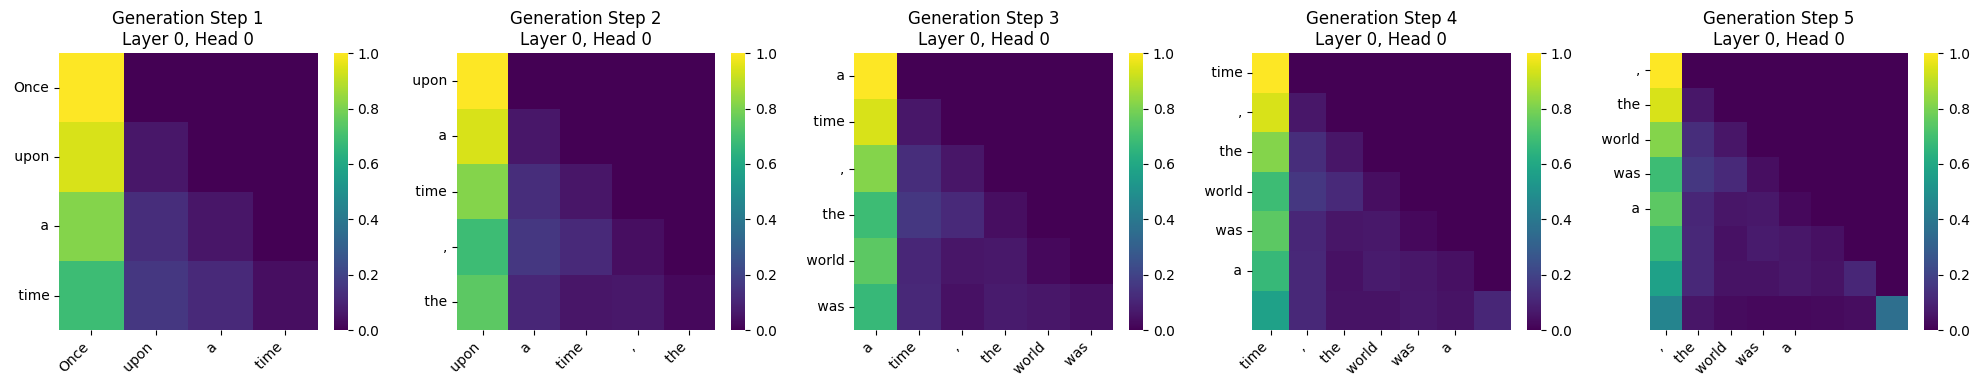

In [12]:
from previous_chapters import text_to_token_ids, token_ids_to_text
import tiktoken
import torch
import matplotlib.pyplot as plt
import seaborn as sns
# Example usage:
# Initialize your model and tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Generate text with attention weights
start_text = "Once upon a time"
input_ids = text_to_token_ids(start_text, tokenizer)
generated_ids, attn_weights = generate_with_attention(
    model, input_ids, 
    max_new_tokens=5, 
    context_size=model.pos_emb.weight.shape[0]
)

# Get the full generated text
generated_text = token_ids_to_text(generated_ids, tokenizer)

# Visualize attention patterns
# For example, visualize layer 0, head 0
fig = visualize_attention(attn_weights, tokenizer, generated_text, layer_idx=0, head_idx=0)
plt.show()